In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import starfile

In [2]:
from scipy.spatial import ConvexHull
def point_in_ConvexHull(hull, pnt):
    '''
    Checks if `pnt` is inside the convex hull.
    `hull` -- a QHull ConvexHull object
    `pnt` -- point array of shape (3,)
    '''
    new_hull = ConvexHull(np.concatenate((hull.points, [pnt])))
    if np.array_equal(new_hull.vertices, hull.vertices): 
        return True
    return False

In [12]:
preclass_particle_star_path = Path("/mnt/scratch/ribosomes/kas_k44a/particle_context/particle_data/preclass_job282_run_data.star")
postclass_particle_star_path = Path("/mnt/scratch/ribosomes/kas_k44a/particle_context/particle_data/postclass_job292_run_data.star")


binning = 10
tomo_dir = Path("/mnt/scratch/ribosomes/kas_k44a/particle_context/surfaces_10tomos/")
max_x = 818 * binning
max_y = 1152 * binning
max_z = 480 * binning
unbinned_pixel_size = 1.0825 # A/px
increment_nm = 10
num_layers = 30
increment_px = increment_nm * 10 / unbinned_pixel_size
print(f"increment_px (unbinned): {increment_px}")
# initialize a df with num_layers rows and 1 column "count"


increment_px (unbinned): 92.37875288683603


In [13]:
preclass_particle_star = starfile.read(preclass_particle_star_path)
postclass_particle_star = starfile.read(postclass_particle_star_path)
preclass_particle_df = preclass_particle_star["particles"]
postclass_particle_df = postclass_particle_star["particles"]

topboundary_points = [
    [0, 0, max_z],
    [0, max_y, max_z],
    [max_x, 0, max_z],
    [max_x, max_y, max_z]
]
topboundary_points_df = pd.DataFrame(topboundary_points, columns=["x", "y", "z"])
bottomboundary_points = [
    [0, 0, 0],
    [0, max_y, 0],
    [max_x, 0, 0],
    [max_x, max_y, 0]
]
bottomboundary_points_df = pd.DataFrame(bottomboundary_points, columns=["x", "y", "z"])

In [14]:
tomo_list = [tomo.name[:6] for tomo in sorted(tomo_dir.glob("*.mod"))]

preclass_particle_df["Context"] = None
postclass_particle_df["Context"] = None
preclass_particles_to_check_df = preclass_particle_df[preclass_particle_df["rlnTomoName"].isin(tomo_list)]
postclass_particles_to_check_df = postclass_particle_df[postclass_particle_df["rlnTomoName"].isin(tomo_list)]


In [20]:
one_iter = False

pre_layer_df = pd.DataFrame(data={"count": np.zeros(num_layers, dtype=int)})
post_layer_df = pd.DataFrame(data={"count": np.zeros(num_layers, dtype=int)})

for tomo_name in tomo_list:
    print(tomo_name)
    pre_tomo_df = preclass_particles_to_check_df[preclass_particles_to_check_df["rlnTomoName"] == tomo_name]
    post_tomo_df = postclass_particles_to_check_df[postclass_particles_to_check_df["rlnTomoName"] == tomo_name]
    print(len(pre_tomo_df))
    print(len(post_tomo_df))

    top_points_file = tomo_dir / f"{tomo_name}_top.xyz"
    top_points_df = pd.read_csv(top_points_file, delim_whitespace=True, header=None, names=["x", "y", "z"]) * binning
    top_points_df = pd.concat([top_points_df, topboundary_points_df])

    # Starting at the top air-water interface, go down in increments of 10 nm.
    # For each increment, check if the particle is inside the convex hull of the surface.
    # If it is, assign the particle to the context of the surface.
    # If it is not, continue to the next increment.

    for layer in range(num_layers):
        top_ConvexHull = ConvexHull(top_points_df)

        # Check if each particle is inside the convex hull
        for i, particle in pre_tomo_df.iterrows():
            if particle["Context"] is not None:
                continue
            particle_coords = np.array([particle["rlnCoordinateX"], particle["rlnCoordinateY"], particle["rlnCoordinateZ"]])
            #print(particle_coords)
            if point_in_ConvexHull(top_ConvexHull, particle_coords):
                #print(f"Particle {i} is in layer {layer}")
                # Set the "Context" of the particle to the layer number
                pre_tomo_df.at[i, "Context"] = layer

        # print the total number of particles found in this layer

        for i, particle in post_tomo_df.iterrows():
            if particle["Context"] is not None:
                continue
            particle_coords = np.array([particle["rlnCoordinateX"], particle["rlnCoordinateY"], particle["rlnCoordinateZ"]])
            if point_in_ConvexHull(top_ConvexHull, particle_coords):
                post_tomo_df.at[i, "Context"] = layer
        
        pre_layer_df.at[layer, "count"] += len(pre_tomo_df[pre_tomo_df["Context"] == layer])
        post_layer_df.at[layer, "count"] += len(post_tomo_df[post_tomo_df["Context"] == layer])
        top_points_df["z"] -= increment_px

    if one_iter == True:
        break

ts_003
394
384
ts_004
911
865
ts_006
425
420


/tmp/ipykernel_3104805/4266156844.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{i * increment_nm}" for i in ax.get_xticks()])


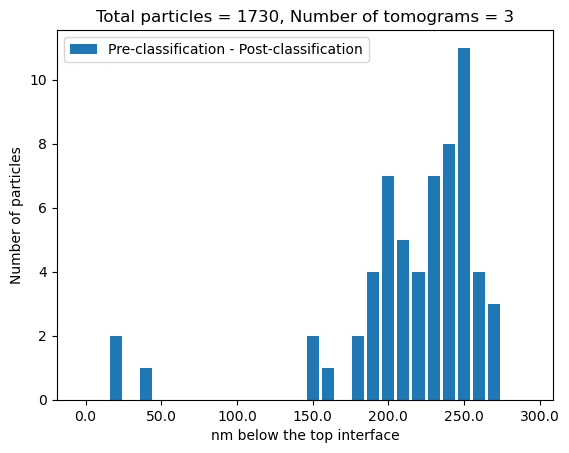

In [29]:
#plot the number of particles in each layer
fig, ax = plt.subplots()
#ax.plot(pre_layer_df.index, pre_layer_df["count"], label="Pre-classification")
#ax.plot(post_layer_df.index, post_layer_df["count"], label="Post-classification")
# plot the difference as a bar chart
ax.bar(pre_layer_df.index, pre_layer_df["count"] - post_layer_df["count"], label="Pre-classification - Post-classification")
ax.set_xlabel("nm below the top interface")
# change the tick labels to nm
ax.set_xticklabels([f"{i * increment_nm}" for i in ax.get_xticks()])
ax.set_ylabel("Number of particles")
ax.set_title(f"Total particles = {len(preclass_particles_to_check_df)}, Number of tomograms = {len(tomo_list)}")
ax.legend()
